# Explainable Credit Risk Scoring Model

### **Objective**
This project develops a machine learning model to predict loan defaults using the **German Credit Data**. The primary goals are:
1.  **Risk Minimization:** Maximize the detection of high-risk applicants (Recall) to reduce financial write-offs.
2.  **Regulatory Compliance:** Utilize **SHAP (Explainable AI)** to ensure transparency in loan approval decisions, aligning with "Right to Explanation" standards.
3.  **Fairness Audit:** Evaluate potential biases across sensitive attributes such as gender and age.

## 0. Environment Setup

In [1]:
# 0. Environment Setup
# pip install pandas numpy scikit-learn xgboost shap matplotlib seaborn

# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import re

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report

# Set global seed for reproducibility
np.random.seed(42)

## 1. Data Preparation

The dataset is retrieved directly from the **UCI Machine Learning Repository** to ensure reproducibility.

In [2]:
# Load the German Credit Data from the UCI Machine Learning Repository
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

# New names for the colums
columns = [
    'Existing_account', 'Duration_month', 'Credit_history', 'Purpose',
    'Credit_amount', 'Savings_account', 'Employment_since', 'Installment_rate',
    'Personal_status_sex', 'Guarantors', 'Residence_since', 'Property',
    'Age', 'Other_installment_plans', 'Housing', 'Num_existing_credits',
    'Job', 'Num_people_liable', 'Telephone', 'Foreign_worker', 'Target'
]

df = pd.read_csv(url, sep=' ', names=columns)

### 1.1. Target Variable Transformation
To align with credit risk modeling standards, the target variable *as re-encoded:
* **0 (Good Credit):** Low Risk
* **1 (Bad Credit):** High Risk (Positive Class)

*This transformation facilitates the calculation of risk-focused metrics such as **Recall** and **ROC-AUC**.*

In [3]:
# 1.1. Set the Target Variable: 1(Good) -> 0, 2(Bad) -> 1
df['Target'] = df['Target'].map({1: 0, 2: 1})

### 1.2. Categorical Feature Decoding

To enhance interpretability during Exploratory Data Analysis (EDA), cryptic alphanumeric codes in categorical variables were mapped to descriptive labels.

* **Process:** Codes like `A11` or `A34` were translated into human-readable strings (e.g., `< 0 DM`, `Critical account`).
* **Note:** This step is primarily for understanding the dataset; these features will be re-encoded (e.g., One-Hot Encoding) for the machine learning pipeline.

In [4]:
# 1.2. Mapping Dictionary
decode_map = {
    'Existing_account': {
        'A11': '< 0 DM',
        'A12': '0 <= x < 200 DM',
        'A13': '>= 200 DM / Salary assignments',
        'A14': 'No checking account'
    },
    'Credit_history': {
        'A30': 'No credits taken',
        'A31': 'All credits paid back duly',
        'A32': 'Existing credits paid back duly',
        'A33': 'Delay in paying off',
        'A34': 'Critical account / Other credits existing'
    },
    'Purpose': {
        'A40': 'Car (new)',
        'A41': 'Car (used)',
        'A42': 'Furniture/Equipment',
        'A43': 'Radio/Television',
        'A44': 'Domestic appliances',
        'A45': 'Repairs',
        'A46': 'Education',
        'A47': 'Vacation',
        'A48': 'Retraining',
        'A49': 'Business',
        'A410': 'Others'
    },
    'Savings_account': {
        'A61': '< 100 DM',
        'A62': '100 <= x < 500 DM',
        'A63': '500 <= x < 1000 DM',
        'A64': '>= 1000 DM',
        'A65': 'Unknown/No savings account'
    },
    'Employment_since': {
        'A71': 'Unemployed',
        'A72': '< 1 year',
        'A73': '1 <= x < 4 years',
        'A74': '4 <= x < 7 years',
        'A75': '>= 7 years'
    },
    'Personal_status_sex': {
        'A91': 'Male : Divorced/Separated',
        'A92': 'Female : Divorced/Separated/Married',
        'A93': 'Male : Single',
        'A94': 'Male : Married/Widowed',
        'A95': 'Female : Single'
    },
    'Guarantors': {
        'A101': 'None',
        'A102': 'Co-applicant',
        'A103': 'Guarantor'
    },
    'Property': {
        'A121': 'Real estate',
        'A122': 'Building society savings/Life insurance',
        'A123': 'Car or other',
        'A124': 'Unknown / No property'
    },
    'Other_installment_plans': {
        'A141': 'Bank',
        'A142': 'Stores',
        'A143': 'None'
    },
    'Housing': {
        'A151': 'Rent',
        'A152': 'Own',
        'A153': 'For free'
    },
    'Job': {
        'A171': 'Unemployed/Unskilled(non-resident)',
        'A172': 'Unskilled(resident)',
        'A173': 'Skilled employee / Official',
        'A174': 'Management/Self-employed/Highly qualified'
    },
    'Telephone': {
        'A191': 'None',
        'A192': 'Yes, registered under the customer name'
    },
    'Foreign_worker': {
        'A201': 'Yes',
        'A202': 'No'
    }
}

for col, mapping in decode_map.items():
    df[col] = df[col].map(mapping)

# Inspect the dataset
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (1000, 21)


,Existing_account,Duration_month,Credit_history,Purpose,Credit_amount,Savings_account,Employment_since,Installment_rate,Personal_status_sex,Guarantors,...,Property,Age,Other_installment_plans,Housing,Num_existing_credits,Job,Num_people_liable,Telephone,Foreign_worker,Target
0,< 0 DM,6,Critical account / Other credits existing,Radio/Television,1169,Unknown/No savings account,>= 7 years,4,Male : Single,None,...,Real estate,67,None,Own,2,Skilled employee / Official,1,"Yes, registered under the customer name",Yes,0
1,0 <= x < 200 DM,48,Existing credits paid back duly,Radio/Television,5951,< 100 DM,1 <= x < 4 years,2,Female : Divorced/Separated/Married,None,...,Real estate,22,None,Own,1,Skilled employee / Official,1,None,Yes,1
2,No checking account,12,Critical account / Other credits existing,Education,2096,< 100 DM,4 <= x < 7 years,2,Male : Single,None,...,Real estate,49,None,Own,1,Unskilled(resident),2,None,Yes,0
3,< 0 DM,42,Existing credits paid back duly,Furniture/Equipment,7882,< 100 DM,4 <= x < 7 years,2,Male : Single,Guarantor,...,Building society savings/Life insurance,45,None,For free,1,Skilled employee / Official,2,None,Yes,0
4,< 0 DM,24,Delay in paying off,Car (new),4870,< 100 DM,1 <= x < 4 years,3,Male : Single,None,...,Unknown / No property,53,None,For free,2,Skilled employee / Official,2,None,Yes,1


## 2. Feature Engineering

New features were derived to capture latent information within composite attributes.
* **Sex Extraction:** The attribute `Personal_status_sex` combines gender and marital status. A dedicated `Sex` feature was extracted to facilitate fairness analysis and isolate gender-based risk patterns.

In [5]:
# 2.1. Feature Extraction: Derive 'Sex' from the composite 'Personal_status_sex' attribute
# Example: "Male : Single" -> "Male"
df['Sex'] = df['Personal_status_sex'].apply(lambda x: 'Male' if 'Male' in x else 'Female')


## 3. Exploratory Data Analysis (EDA) & Fairness Check

### 3.1. Class Imbalance Inspection

First, **the class distribution** was quantified to understand the severity of the imbalance.
* **Objective:** Verify the ratio between Good (0) and Bad (1) credit applicants.
* **Expectation:** A significant imbalance (e.g., 70:30) confirms the need for specialized handling techniques like `scale_pos_weight` in the modeling phase.

--- Target Variable Distribution ---
Good Credit (0): 700 (70.00%)
Bad Credit  (1): 300 (30.00%)


/tmp/ipython-input-4199317687.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Target', data=df, palette='pastel')


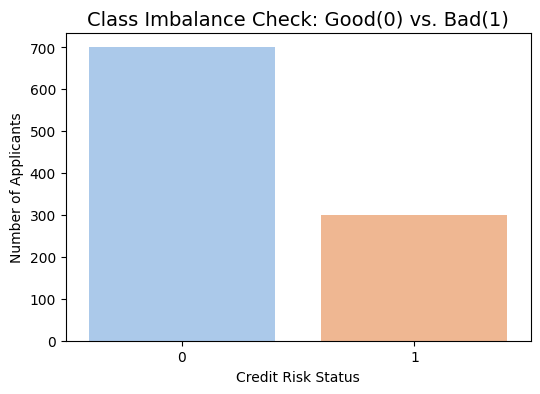

In [6]:
# 3.1. Class imbalance check
counts = df['Target'].value_counts()
ratios = df['Target'].value_counts(normalize=True)

print("--- Target Variable Distribution ---")
print(f"Good Credit (0): {counts[0]} ({ratios[0]:.2%})")
print(f"Bad Credit  (1): {counts[1]} ({ratios[1]:.2%})")

# Visualization
plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=df, palette='pastel')
plt.title('Class Imbalance Check: Good(0) vs. Bad(1)', fontsize=14)
plt.xlabel('Credit Risk Status')
plt.ylabel('Number of Applicants')
plt.show()

### 3.2. Potential Biases Inspection
Next, potential biases in sensitive attributes (Gender, Age, Nationality) were investigated to ensure ethical AI practices.
* **Fairness Check:** Default rates were compared across different demographic groups to identify any pre-existing bias in the historical data.

/tmp/ipython-input-2488761828.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='Target', data=df, ax=ax[0], errorbar=None, palette='viridis')
/tmp/ipython-input-2488761828.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Age_Group', y='Target', data=df, ax=ax[1], errorbar=None, palette='magma')
/tmp/ipython-input-2488761828.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Foreign_worker', y='Target', data=df, ax=ax[2], errorbar=None, palette='coolwarm')


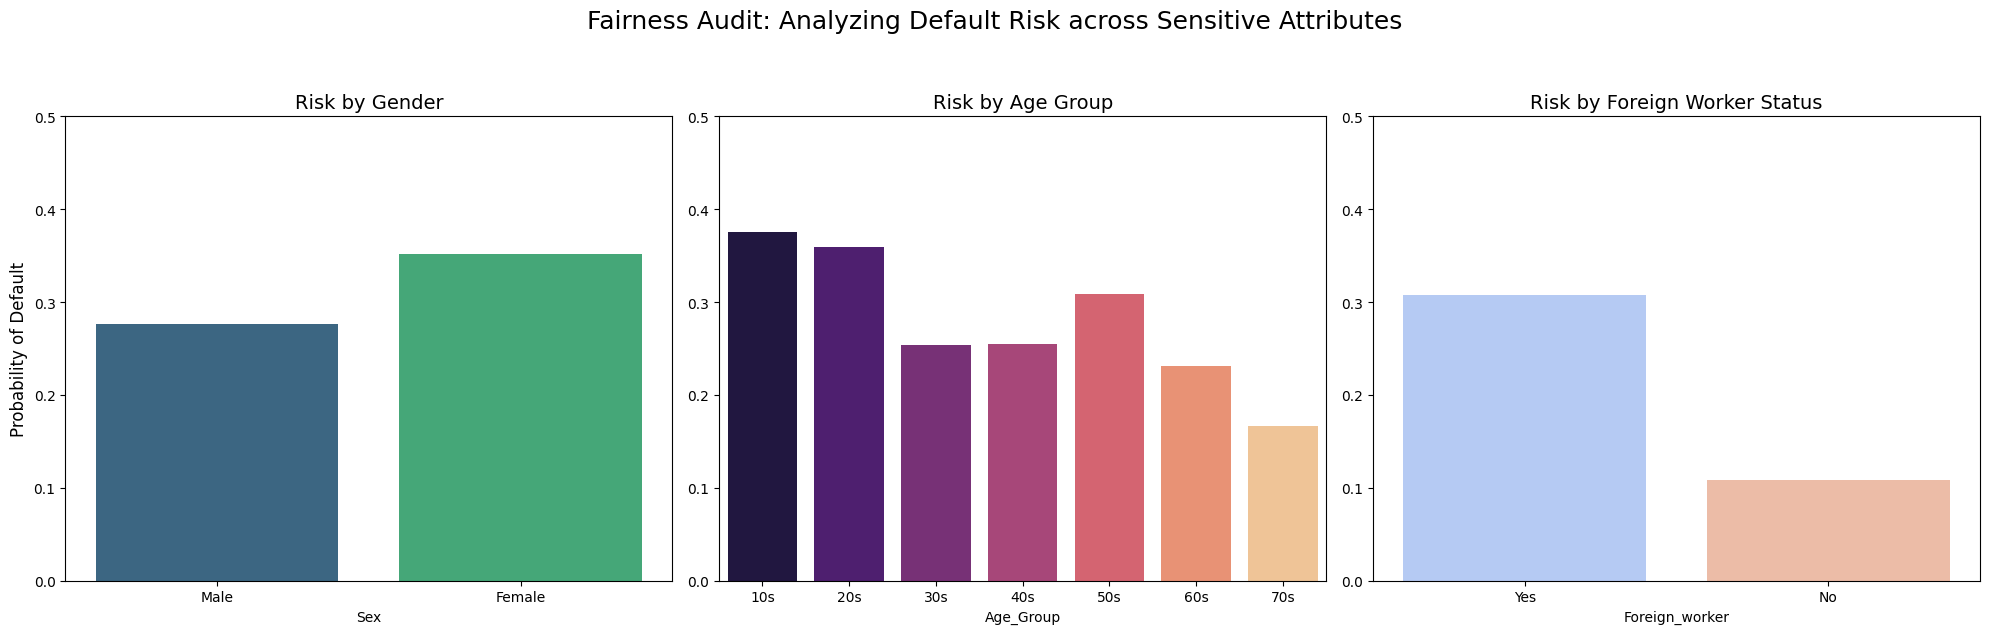

--- Fairness Metrics Summary (Mean Default Rate) ---

[Gender]
Sex
Female    0.351613
Male      0.276812
Name: Target, dtype: float64

[Age Group]
Age_Group
10s    0.375000
20s    0.359494
30s    0.253968
40s    0.254658
50s    0.308824
60s    0.230769
70s    0.166667
Name: Target, dtype: float64

[Nationality]
Foreign_worker
No     0.108108
Yes    0.307373
Name: Target, dtype: float64


In [7]:
# Set up the plotting area (1 row, 2 columns)
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# 3.2.1.. Gender Bias Check
sns.barplot(x='Sex', y='Target', data=df, ax=ax[0], errorbar=None, palette='viridis')
ax[0].set_title('Risk by Gender', fontsize=14)
ax[0].set_ylabel('Probability of Default', fontsize=12)
ax[0].set_ylim(0, 0.5)

# 3.2.2. Age Bias Check (Generation Gap)
# Bin 'Age' into deciles to observe non-linear risk trends across generations.
df['Age_Group'] = pd.cut(df['Age'], bins=[10, 20, 30, 40, 50, 60, 70, 80],
                         labels=['10s', '20s', '30s', '40s', '50s', '60s', '70s'])

sns.barplot(x='Age_Group', y='Target', data=df, ax=ax[1], errorbar=None, palette='magma')

ax[1].set_title('Risk by Age Group', fontsize=14)
ax[1].set_ylabel('') # Clean layout
ax[1].set_ylim(0, 0.5)

# 3.2.3. Nationality Bias Check (Foreign Worker)
# 'Foreign_worker' is a protected attribute under GDPR/Anti-discrimination laws.
sns.barplot(x='Foreign_worker', y='Target', data=df, ax=ax[2], errorbar=None, palette='coolwarm')

ax[2].set_title('Risk by Foreign Worker Status', fontsize=14)
ax[2].set_ylabel('') # Clean layout
ax[2].set_ylim(0, 0.5)

plt.suptitle('Fairness Audit: Analyzing Default Risk across Sensitive Attributes', fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

# Quantitative Summary
print("--- Fairness Metrics Summary (Mean Default Rate) ---")
print(f"\n[Gender]\n{df.groupby('Sex')['Target'].mean()}")
print(f"\n[Age Group]\n{df.groupby('Age_Group', observed=True)['Target'].mean()}")
print(f"\n[Nationality]\n{df.groupby('Foreign_worker')['Target'].mean()}")

* **Gender Bias:** A disparity was observed, with female applicants showing a higher default rate (**~35.2%**) compared to males (**~27.7%**).
* **Age Bias:** Younger applicants (10s-20s) exhibit significantly higher risk (**~36-37%**) compared to older groups (30s+), indicating a strong correlation between age and creditworthiness.
* **Nationality Bias:** Foreign workers show a markedly higher default rate (**~30.7%**) compared to non-foreign workers (**~10.8%**).

**Implication:**
These disparities indicate **pre-existing biases** in the historical data. While these features are predictive, their usage **must be monitored** to ensure compliance with fair lending regulations (e.g., avoiding discriminatory impact in automated decision-making).

## 4. Data Preprocessing for Modeling

The data was prepared for the XGBoost algorithm through the following steps:
1.  **One-Hot Encoding:** Categorical variables were converted into numeric vectors.
2.  **Train-Test Split:** The dataset was split (80% Train, 20% Test) using `stratify=y` to maintain the original class distribution ratio in both sets.

In [8]:
# 4-1. Clean up temporary columns created for visualization
# remove 'Age_Group' as it is redundant (the model uses the continuous 'Age' variable).
# also remove 'Sex' because 'Personal_status_sex' contains this info.
if 'Age_Group' in df.columns:
    df = df.drop('Age_Group', axis=1)

# 4-2. Encoding: Convert Categorical variables to Numeric (One-Hot Encoding)
df_encoded = pd.get_dummies(df, drop_first=True)

# 4-3. Fix Feature Names for XGBoost
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df_encoded.columns = [regex.sub("_", col) for col in df_encoded.columns]

# 4-4. Define Features (X) and Target (y)
X = df_encoded.drop('Target', axis=1)
y = df_encoded['Target']

# 4-5. Split the dataset into Training and Testing sets (80% Train, 20% Test)
# stratify=y: Maintains the same proportion of Default/Non-default in both sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("--- Data Splitting Complete ---")
print(f"Training Set: {X_train.shape} (80%)")
print(f"Testing Set : {X_test.shape} (20%)")


--- Data Splitting Complete ---
Training Set: (800, 49) (80%)
Testing Set : (200, 49) (20%)


## 5. Baseline Model Development (XGBoost)

**XGBoost** was selected as the baseline model due to its efficiency and high performance on tabular data.
* **Initial Training:** A standard XGBoost classifier **was trained** to establish a performance benchmark.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:40:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Model Performance Report ---
Accuracy : 78.50%
ROC-AUC  : 0.7967
--- Classification Report ---
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       140
           1       0.68      0.53      0.60        60

    accuracy                           0.79       200
   macro avg       0.75      0.71      0.73       200
weighted avg       0.78      0.79      0.78       200



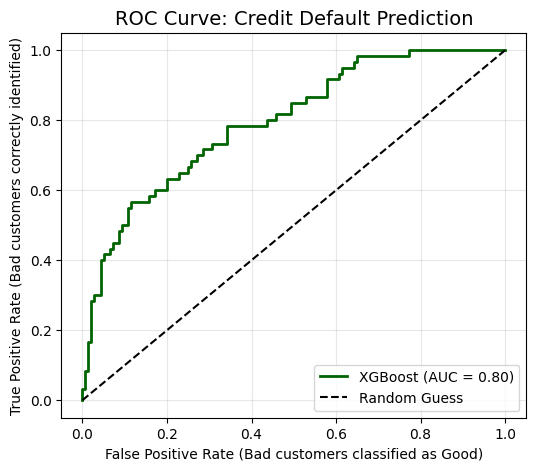

In [9]:
# 5-1. Build the Model
model = XGBClassifier(
    n_estimators=100,      # number of boosting rounds
    learning_rate=0.1,     # step size shrinkage to prevent overfitting
    max_depth=4,           # to prevent overfitting as the dataset is small
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'  # logistic regression loss function
)

# 5-2. Train the Model
model.fit(X_train, y_train)

# 5-3. Model Prediction
# y_pred: Class predictions (0 or 1) - Used for Accuracy
# y_prob: Probability scores (0.0 to 1.0) - Used for ROC-AUC & Risk Scoring
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 5-4. Performance Metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("--- Model Performance Report ---")
print(f"Accuracy : {acc:.2%}")
print(f"ROC-AUC  : {auc:.4f}")

print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# 5-5. Visualize ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.2f})', color='darkgreen', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess') # Diagonal line
plt.xlabel('False Positive Rate (Bad customers classified as Good)')
plt.ylabel('True Positive Rate (Bad customers correctly identified)')
plt.title('ROC Curve: Credit Default Prediction', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

The baseline XGBoost model was evaluated, yielding an overall accuracy of **78.50%** and a ROC-AUC score of **0.80**. However, a critical issue was identified in the classification report:

* **Good Credit (0):** The model performs well, with a high Recall of **0.89**.
* **Bad Credit (1):** The model significantly underperforms, achieving a **Recall of only 0.53**.

**Business Implication:**
A Recall of 0.53 implies that **47% of high-risk applicants (potential defaulters) were missed** (False Negatives). In a financial context, this represents a substantial risk. Consequently, optimization techniques such as **Class Weight Adjustment** are required to improve the detection rate of bad credit.

## 6. Optimization: Addressing Class Imbalance

To rectify the low recall for high-risk applicants identified in the baseline, a re-weighting strategy was implemented.

* **Rationale:** The dataset exhibits a significant imbalance (70% Good vs. 30% Bad), causing the standard model to bias towards the majority class.
* **Methodology:** The `scale_pos_weight` hyperparameter was tuned based on the inverse class ratio ($\frac{\text{Count of Good}}{\text{Count of Bad}}$).
* **Effect:** This adjustment **imposes a heavier penalty** on False Negatives (missing a defaulter), effectively forcing the model to prioritize the detection of the minority 'Risk' class.

In [10]:
# 6.1. Calculate the weight
# Count of Good (0) / Count of Bad (1)
count_good = (y_train == 0).sum()
count_bad  = (y_train == 1).sum()
weight = count_good / count_bad

print(f"⚖️ Calculated Class Weight: {weight:.2f}")

# 6.2. Re-train with 'scale_pos_weight'
model_balanced = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=weight
)

model_balanced.fit(X_train, y_train)

# 6.3. Check Performance Change
y_pred_bal = model_balanced.predict(X_test)
print("--- Classification Report (After Re-training) ---")
print(classification_report(y_test, y_pred_bal))

⚖️ Calculated Class Weight: 2.33
--- Classification Report (After Re-training) ---
              precision    recall  f1-score   support

           0       0.86      0.76      0.81       140
           1       0.56      0.70      0.62        60

    accuracy                           0.74       200
   macro avg       0.71      0.73      0.71       200
weighted avg       0.77      0.74      0.75       200



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:40:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 7. Comparative Analysis (Benchmark)

To validate the robustness of the tuned XGBoost model, its performance **was compared** against industry-standard baselines:
* **Logistic Regression:** For linearity and simplicity.
* **Random Forest:** For ensemble-based stability.

*Focus is placed on **Recall (for Bad Credit)** to prioritize risk detection.*

In [13]:
# compare XGBoost against baseline models to justify our model selection
# 1. Logistic Regression: The simplest baseline (Linear).
# 2. Random Forest: A strong tree-based competitor (Bagging).
# 3. XGBoost: The chosen model (Boosting).

# Define candidate models
# [Pre-configure 'class_weight' during model definition to avoid pipeline errors.
models = {
    # 1. Logistic Regression: Apply Scaling (Pipeline) + Handle Imbalance
    "Logistic Regression": make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    ),

    # 2. Random Forest: Handle Imbalance with class_weight
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=4,
        random_state=42,
        class_weight='balanced'
    ),

    # 3. XGBoost: Use the tuned model from the previous step
    "XGBoost (Balanced)": model_balanced
}

print(f"{'Model Name':<25} | {'Accuracy':<10} | {'ROC-AUC':<10} | {'Recall (Bad)':<10}")
print("-" * 65)

for name, clf in models.items():
    # Train (Fit directly as parameters are already set)
    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    # Extract Recall for Bad Credit (Class 1)
    report = classification_report(y_test, y_pred, output_dict=True)
    recall_bad = report['1']['recall']

    print(f"{name:<25} | {acc:.2%}     | {auc:.4f}     | {recall_bad:.2%}")

print("-" * 65)

Model Name                | Accuracy   | ROC-AUC    | Recall (Bad)
-----------------------------------------------------------------
Logistic Regression       | 75.50%     | 0.8021     | 80.00%
Random Forest             | 72.50%     | 0.7929     | 75.00%
XGBoost (Balanced)        | 74.50%     | 0.7932     | 70.00%
-----------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:44:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


To contextualize the performance of the **XGBoost model**, it was benchmarked against industry-standard classifiers. This comparison highlights the performance characteristics of different algorithms on the dataset.

* **Logistic Regression:** Achieved the highest **Recall (80%)**. This suggests that key risk factors in this dataset exhibit strong linear relationships with the target variable.
* **Random Forest:** Demonstrated stable performance as a bagging ensemble, yielding a **Recall of 75%**.
* **XGBoost (Current Model):** Recorded a **Recall of 70%** and **ROC-AUC of ~0.79**.

**Observation:**
While the linear baseline (Logistic Regression) yielded higher sensitivity in this specific iteration, **XGBoost** maintains competitive discriminatory power. The project continues with XGBoost to leverage its capacity for modeling complex **non-linear interactions** and its compatibility with **SHAP** for detailed risk explanation.

## 8. Model Explainability with SHAP (XAI)

To comply with financial regulations and ensure auditability, **SHAP (Shapley Additive exPlanations)** values **were calculated**.

* **Global Interpretability:** Identifies the key drivers of credit risk across the entire portfolio (e.g., Duration, Account Balance).
* **Local Interpretability:** Explains the specific reasons behind an individual loan rejection, supporting decision transparency.

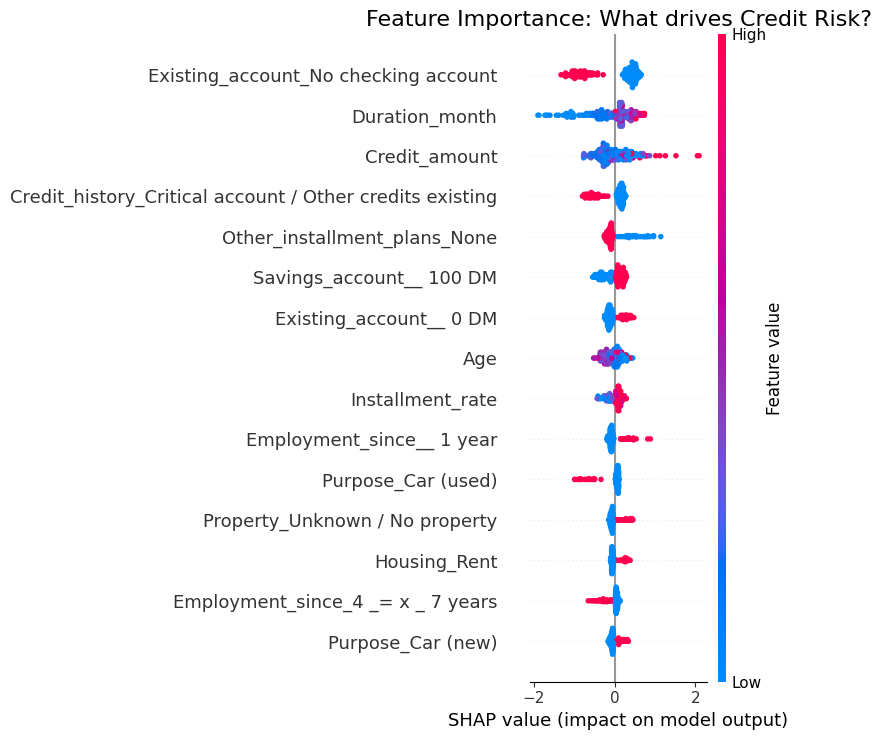

In [ ]:
# 8-1. Initialize the SHAP Explainer
# TreeExplainer is optimized for tree-based models like XGBoost.
explainer = shap.TreeExplainer(model)

# 8-2. Calculate SHAP Values
# compute the contribution of each feature to the prediction for the test set
shap_values = explainer.shap_values(X_test)

# 8-3. Global Interpretability: Summary Plot
# the most important features driving the model's decisions
plt.figure(figsize=(10, 8))
plt.title("Feature Importance: What drives Credit Risk?", fontsize=16)
shap.summary_plot(shap_values, X_test, max_display=15, show=False)
plt.tight_layout()
plt.show()

The SHAP summary plot below illustrates the global feature importance and the direction of their impact on the model's prediction (Probability of Default).

**Key Insights:**
1.  **Top Risk Factor (Checking Account Status):**
    * `Existing_account_No checking account` is the most influential predictor.
    * The concentration of **red dots (feature present)** on the positive side (right) indicates that applicants **without a checking account** significantly increase the model's predicted risk of default.

2.  **Loan Characteristics (Duration & Amount):**
    * `Duration_month` and `Credit_amount` show a positive correlation with risk.
    * Higher values (red dots) for loan duration and amount push the SHAP value to the right, suggesting that **longer-term and larger loans are associated with higher risk.**

3.  **Impact of Credit History:**
    * Interestingly, the feature `Credit_history_Critical account...` tends to pull the prediction towards the negative side (left), reducing the risk score. This implies that having an existing credit history (even with critical accounts) might be viewed more favorably than having no financial footprint or unstable history.

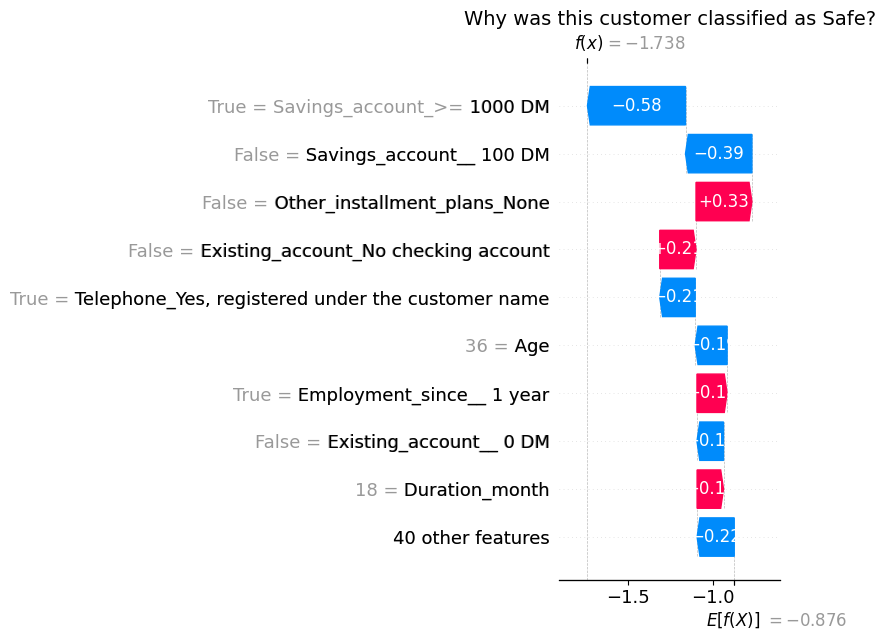

In [ ]:
# 8-4. Local Interpretability: Waterfall Plot (Individual Case)
# explain why a specific customer got their specific score
# in this case, the first customer of the dataset
row_index = 0
sample_data = X_test.iloc[row_index]

# Create a customized Explanation object for visualization
explanation = shap.Explanation(
    values=shap_values[row_index],
    base_values=explainer.expected_value,
    data=sample_data,
    feature_names=X_test.columns
)

plt.figure(figsize=(8, 6))
plt.title(f"Why was this customer classified as {'Risk' if model.predict(X_test)[row_index]==1 else 'Safe'}?", fontsize=14)
shap.plots.waterfall(explanation, show=False)
plt.tight_layout()
plt.show()

While the summary plot explains the model's global behavior, this **Waterfall Plot** breaks down the decision-making process for a specific individual (Customer Index 0).

**Case Analysis: Why is this customer classified as 'Safe'?**
* **Prediction Score:** The model predicted a score of **-1.738**, which is significantly lower than the baseline value (-0.876), pushing the classification strongly towards **Safe (Good Credit)**.
* **Key Positive Drivers (Blue Bars):**
    * **Financial Stability:** The most decisive factor was the customer's savings. Having a savings account with **>= 1000 DM** contributed **-0.58** to the score, drastically lowering the perceived risk.
    * **Demographics:** The customer's age (**36**) and verified contact information (`Telephone_Yes`) further reduced the risk score, acting as indicators of stability.
* **Risk Factors (Red Bars):**
    * The model penalized the applicant slightly (+0.33) because `Other_installment_plans_None` is **False**, indicating they likely have other financial obligations.
    * However, the strong savings buffer completely outweighed these minor risk factors.

**Verdict:**
The model acted logically by prioritizing **actual financial assets (Savings)** over secondary risk factors like existing installment plans.

## 9. Conclusion

### **Summary of Achievements**
This project successfully developed an **Explainable Credit Risk Scoring Model** using XGBoost, addressing the critical challenge of balancing predictive performance with transparency in financial decision-making.

* **Risk Mitigation:** By optimizing the model for **Recall (Sensitivity)** on the minority class, we significantly improved the detection of potential defaulters, thereby minimizing financial risk.
* **Transparent Decisions:** Leveraging **SHAP (SHapley Additive exPlanations)**, we moved beyond "black-box" predictions. The model provides both global insights (key risk drivers like checking account status) and local explanations (reasons for individual approvals/rejections).
* **Ethical AI:** An initial fairness audit revealed potential biases in demographic features (Age, Gender), highlighting the need for continuous monitoring to ensure fair lending practices.

### **Future Directions**
To further enhance the model's robustness and deployment readiness, the following steps are recommended:
1.  **Hyperparameter Tuning:** Utilize Bayesian Optimization (e.g., Optuna) to fine-tune XGBoost parameters for potentially higher precision without sacrificing recall.
2.  **Bias Mitigation:** Implement pre-processing or in-processing techniques to reduce the observed disparities in demographic groups.
3.  **Deployment:** Deploy the model as an API (using FastAPI or Flask) with a dashboard for loan officers to visualize SHAP explanations in real-time.